# Geothermal and Machine Learning Sandbox

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

import pickle

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from scipy.ndimage import gaussian_filter

from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load packages to create dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch import Tensor

# from torchvision import models
from torchsummary import summary

import datetime
import time

from pathlib import Path
import sys

import h5py

from tqdm.notebook import trange, tqdm

%matplotlib inline

In [2]:
resultsPath = './results/'

## BEGIN data preprocessing

### preprocessed data

In [3]:
path = '../../datasets/'

filename = 'PFA_features&labels_march2021_tc2_imbalanced_SmoothLSS_FSS_df.h5'

hf5File = path+filename

### a geotiff base map to use for affine transforms

In [4]:
path = '../../datasets/'

basemapFilename = 'BNN_(+)_q-0.05_avg-8192.tif'

basemapFile = path+basemapFilename

### some reference maps

In [5]:
path = '../../datasets/'

referencemapsFilename = 'PFA_reference_maps.h5'

referencemapsFile = path+referencemapsFilename

### geochemistry temperature data

In [6]:
path = '../../datasets/'

geochemTFilename = 'geochemT_training_sites.pkl'

geochemTFile = path+geochemTFilename

### read data from files

In [7]:
f = h5py.File(hf5File, 'r')

def keys(f):
    return [key for key in f.keys()]

key_list = keys(f)
print(key_list)

f.close()

['X', 'XyInfo', 'dfInfo', 'dfn', 'nullIndexes', 'scaler', 'y']


In [8]:
df_reference_maps = pd.read_hdf(referencemapsFile, 'df_reference_maps')

In [9]:
domain = df_reference_maps['domain'].copy().to_numpy()
domain = np.reshape(domain,(1000,-1))

In [10]:
hill = df_reference_maps['hillshade'].copy().to_numpy()
hill = np.reshape(hill,(1000,-1))

# pare down info files and add target column

## get training site features for PCA/UMAP studies

In [11]:
dfn = pd.read_hdf(hf5File, key='dfn')
dfInfo = pd.read_hdf(hf5File, key='dfInfo')

In [12]:
dfXyInfo = pd.read_hdf(hf5File, key='XyInfo')
dfX = pd.read_hdf(hf5File, key='X')
dfy = pd.read_hdf(hf5File, key='y')

df_posInfo = dfXyInfo[dfy == 1].copy()
df_negInfo = dfXyInfo[dfy == 0].copy()
df_posX = dfX[dfy == 1].copy()
df_negX = dfX[dfy == 0].copy()

df_posInfo['class'] = 'pos'
df_negInfo['class'] = 'neg'

In [13]:
columns = dfn.columns.to_list()
# columns

## save heatflow map as a reference

In [14]:
hfMap = dfn['Heatflow'].copy().to_numpy()
hfMap = np.reshape(hfMap,(1000,-1))

## select feature set

In [15]:
featureSets = [

# MASTER SET 1
################################# 0
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],

# MASTER SET 1 - heatflow
################################# 0
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 # 'Heatflow',
 'DEM-30m',
],
]

print (len(featureSets))

2


In [16]:
feature_set = 0

columns = featureSets[feature_set]

columns

['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

## END data preprocessing

## fix input types and dimensions

#### entire study area

In [17]:
df_Xall = dfn[columns].copy()

#### classification training sites

In [18]:
df_posX = df_posX[columns]
df_negX = df_negX[columns]

In [19]:
nFeatures = df_Xall.shape[1]
nFeatures

10

In [20]:
print (df_Xall.shape)

(1728000, 10)


## read in geochemistry temperature dataframe

In [21]:
df_geoTRC = pd.read_pickle(geochemTFile)

In [22]:
df_geoTRC.reset_index(drop=True, inplace=True)

### there are multiple values per pixel
### ... find a typical value

In [23]:
df_geoTRC.columns

Index(['lat_degrees', 'lon_degrees', 'lat_meters', 'lon_meters', 'row', 'col',
       'id_rc', 'geochemT_sio2', 'geochemT_k_mg', 'geochemT_na_k_ca',
       'geochemT_final'],
      dtype='object')

In [24]:
column = 'geochemT_final'

In [25]:
df_geoTRC['avg'] = df_geoTRC.groupby('id_rc')[column].transform('mean')
df_geoTRC['min'] = df_geoTRC.groupby('id_rc')[column].transform('min')
df_geoTRC['max'] = df_geoTRC.groupby('id_rc')[column].transform('max')

In [26]:
df_geoTRC['raw'] = df_geoTRC['avg'].copy()

## truncate first ?

In [27]:
truncate = True
quantile = 0.975

1234 251.154


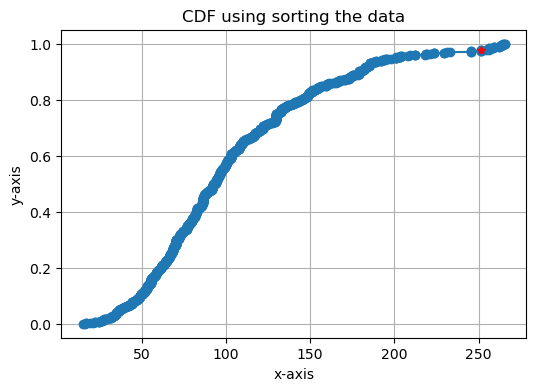

In [28]:
if truncate:

    fig, ax = plt.subplots(figsize=(6,4), nrows=1, ncols=1)
    
    data = df_geoTRC['raw'].values
    # data = df_HFRC['transformed'].values
    
    N = len(data)
            
    # sort the data in ascending order
    x = np.sort(data)
      
    # get the cdf values of y
    y = np.arange(N) / float(N)
    
    # idx = np.where(y>0.9)[0][0]
    idx = np.where(y>quantile)[0][0]
    print(idx, x[idx])
    xQuantile = x[idx]
    
    # plotting
    ax.plot(x[:], y[:], marker='o')
    ax.plot(x[idx], y[idx], color='red', marker='*')
    
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis') 
    ax.set_title('CDF using sorting the data')
    
    ax.grid(True)

    bigIndexes = df_geoTRC[df_geoTRC['raw'] > xQuantile].index
    df_geoTRC.drop(bigIndexes, inplace = True)

### the distribution is skewed
### ... transform to something more like a Gaussian

In [29]:
from sklearn.preprocessing import PowerTransformer
pt_geochemT = PowerTransformer(standardize=True)

transformed = pt_geochemT.fit_transform(df_geoTRC['raw'].values.reshape(-1,1))
df_geoTRC['transformed'] = transformed

# print(pt_heatflow.lambdas_)

### drop duplicates, i.e. get one value per pixel

In [30]:
df_geoTRC = df_geoTRC.drop_duplicates(subset='id_rc')

In [31]:
idrc = df_geoTRC['id_rc']

In [32]:
df_geoTRC_sorted = df_geoTRC.sort_values(by=['id_rc'])

In [33]:
df_geoTExtract = dfInfo[dfInfo['id_rc'].isin(idrc)].copy()

In [34]:
df_geoTExtract_sorted = df_geoTExtract.sort_values(by=['id_rc'])

In [35]:
df_geoTInfo = df_geoTExtract_sorted.iloc[:,:6].copy()
df_geoTInfo['class'] = 'geoT'

In [36]:
raw = df_geoTRC_sorted['raw'].to_numpy()
transformed = df_geoTRC_sorted['transformed'].to_numpy()

df_geoTInfo['raw'] = raw
df_geoTInfo['transformed'] = transformed

## set regression target

In [37]:
# target = df_geoTRC_sorted['raw'].to_numpy()
target = df_geoTRC_sorted['transformed'].to_numpy()

df_geoTInfo['target'] = target

In [38]:
df_geoTInfo = df_geoTInfo.sort_index()

### drop nulls

In [39]:
nullIndexes = df_geoTInfo[df_geoTInfo['NullInfo'] == 'nullValue'].index
df_geoTInfo.drop(nullIndexes, inplace = True)

In [40]:
df_geoTX = df_Xall.loc[df_geoTInfo.index].copy()

In [41]:
df_geoTy = df_geoTInfo['target']

In [42]:
df_geoTX.columns

Index(['QuaternaryFaultTraces', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GeodeticStrainRate', 'QuaternarySlipRate',
       'FaultRecency', 'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow',
       'DEM-30m'],
      dtype='object')

In [43]:
df_geoTy.name

'target'

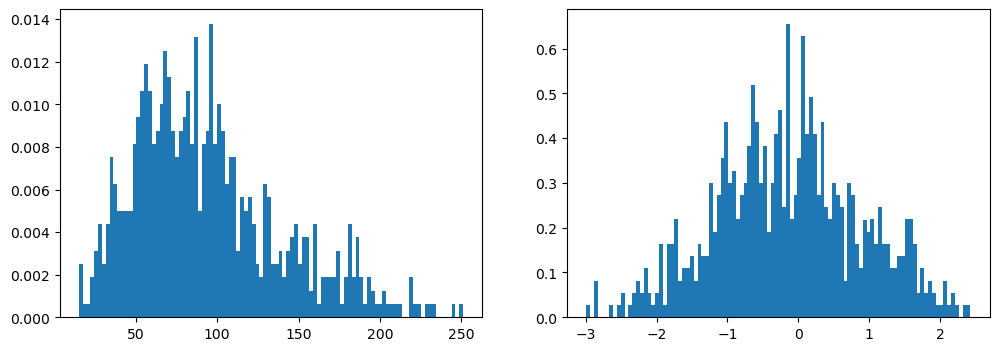

In [44]:
fig, ax = plt.subplots(figsize=(12,4), nrows=1, ncols=2)

ax[0].hist(df_geoTRC['avg'].values, 100, density=True);
# ax[0].hist(df_geoTRC['max'].values, 100, density=True);
ax[1].hist(df_geoTRC['transformed'].values, 100, density=True);

609 1.2580585291876163


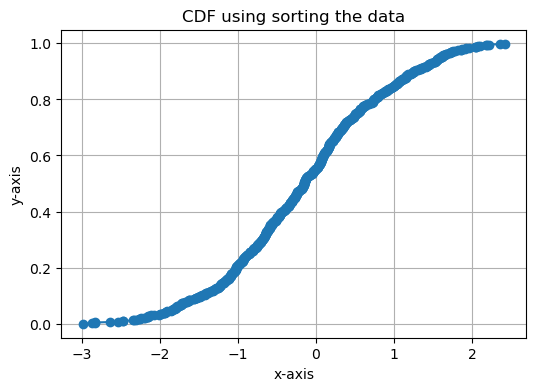

In [45]:
fig, ax = plt.subplots(figsize=(6,4), nrows=1, ncols=1)

data = df_geoTRC['transformed'].values

N = len(data)
        
# sort the data in ascending order
x = np.sort(data)
  
# get the cdf values of y
y = np.arange(N) / float(N)

idx = np.where(y>0.9)[0][0]
# idx = np.where(y>0.97)[0][0]
print(idx, x[idx])
xQuantile = x[idx]
# idx = N

# plotting
ax.plot(x[:], y[:], marker='o')

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis') 
ax.set_title('CDF using sorting the data')

ax.grid(True)

## end selecting data

In [46]:
# df_posInfo.columns.to_list()

In [47]:
info_columns=['row', 'column', 'id_rc', 'X_83UTM11', 'Y_83UTM11', 'NullInfo', 'class']

## now concatenate for later use in PCA/UMAP views of feature space

In [48]:
df_infoClasses = pd.concat([ \
                            df_posInfo[info_columns],
                            df_negInfo[info_columns],
                            df_geoTInfo[info_columns],
                           ],
                           axis=0)

In [49]:
df_infoClasses.columns

Index(['row', 'column', 'id_rc', 'X_83UTM11', 'Y_83UTM11', 'NullInfo',
       'class'],
      dtype='object')

In [50]:
df_XClasses = pd.concat([ \
                         df_posX,
                         df_negX,
                         df_geoTX,
                        ],
                        axis=0)

In [51]:
df_XClasses.columns

Index(['QuaternaryFaultTraces', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GeodeticStrainRate', 'QuaternarySlipRate',
       'FaultRecency', 'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow',
       'DEM-30m'],
      dtype='object')

In [52]:
X = df_XClasses.copy()
y = df_infoClasses['class'].copy()

yint = y.copy()

In [53]:
yint.loc[(y=='neg')]=0
yint.loc[(y=='pos')]=1
yint.loc[(y=='geoT')]=-1

In [54]:
yint

1629211     1
1633596     1
390564      1
1122435     1
1230984     1
           ..
1698037    -1
1698679    -1
1703864    -1
1705591    -1
1713237    -1
Name: class, Length: 1394, dtype: object

In [55]:
y.loc[(y=='neg')]='n'
y.loc[(y=='pos')]='p'
y.loc[(y=='geoT')]='t'

In [56]:
y

1629211    p
1633596    p
390564     p
1122435    p
1230984    p
          ..
1698037    t
1698679    t
1703864    t
1705591    t
1713237    t
Name: class, Length: 1394, dtype: object

## maybe need to random shuffle dataframes

In [57]:
Xs = X.reset_index(drop=True).copy()
ys = y.reset_index(drop=True).copy()
yints = yint.reset_index(drop=True).copy()

In [58]:
# shuffle
# idx = np.random.permutation(Xs.index)

# don't shuffle
idx = Xs.index

In [59]:
X = Xs.reindex(idx)
y = ys.reindex(idx)
yint = yints.reindex(idx)

In [60]:
df_embed = pd.DataFrame(X.copy())
df_embed['y'] = yint

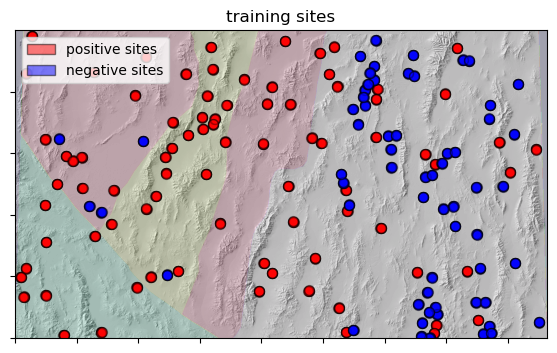

In [61]:
fig, ax = plt.subplots(figsize=(12,4))

ax.imshow(hill, cmap='gray', origin='lower')
ax.imshow(domain, cmap='gist_ncar', alpha=0.1, origin='lower')

ix = df_posInfo['column'].values
iy = df_posInfo['row'].values
ax.scatter(ix,iy, edgecolors='k', 
           marker='o', c='r', alpha=0.5,
           s=50)

ix = df_negInfo['column'].values
iy = df_negInfo['row'].values
ax.scatter(ix,iy, edgecolors='k', 
           marker='o', c='b', alpha=0.5,
           s=50)

ax.set(xticklabels=[]);
ax.set(yticklabels=[]);

ax.set_title('training sites')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(facecolor='red', alpha=0.5, edgecolor='k', label='positive sites')
blue_patch = mpatches.Patch(facecolor='blue', alpha=0.5, edgecolor='k', label='negative sites')

plt.legend(handles=[red_patch, blue_patch])

plt.savefig(resultsPath+'training_sites.png', dpi=300)


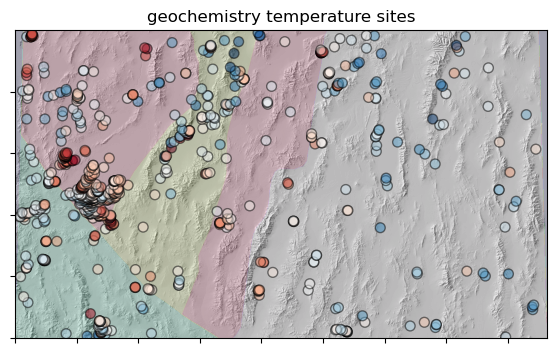

In [62]:
fig, ax = plt.subplots(figsize=(12,4))

ax.imshow(hill, cmap='gray', origin='lower')
ax.imshow(domain, cmap='gist_ncar', alpha=0.1, origin='lower')

c=df_geoTInfo['target'].values

ix = df_geoTInfo['column'].values
iy = df_geoTInfo['row'].values

ax.scatter(ix,iy, edgecolors='k', 
           # marker='o', c='orange', alpha=0.5,
           marker='o', c=c, alpha=0.5,
           cmap='RdBu_r', s=50)

ax.set(xticklabels=[]);
ax.set(yticklabels=[]);

ax.set_title('geochemistry temperature sites')

plt.savefig(resultsPath+'geochemT_sites.png', dpi=300)


### select large number of random sires for PCA/UMAP views
### ... then add these to the training sites

In [63]:
nSamples = 10000

Xsample = df_Xall.copy()

Xsample = Xsample.sample(n=nSamples, random_state=42)

# get rid of nulls from edges of study area which are now zero features
Xsample_nullInfo = dfInfo.loc[Xsample.index, 'NullInfo']
nullIndexes = Xsample[Xsample_nullInfo == 'nullValue'].index
Xsample.drop(nullIndexes, inplace = True)

Xpos   = df_posX.copy()
Xneg   = df_negX.copy()
XgeoT    = df_geoTX.copy()

#### append regression training sites

In [64]:
Xsample = pd.concat([Xsample, Xpos], axis=0, join='outer')
Xsample = pd.concat([Xsample, Xneg], axis=0, join='outer')
# Xsample = pd.concat([Xsample, XgeoT], axis=0, join='outer')
ysample = df_reference_maps['domain'].copy().loc[Xsample.index]

In [65]:
df_embed = pd.DataFrame(Xsample.copy())

## PCA

In [66]:
from sklearn.decomposition import PCA

In [67]:
pca = PCA(n_components=2)

pcaFit = pca.fit(Xsample.to_numpy())

# embedX = reducer.transform(X.copy())
embedX = pcaFit.transform(Xsample.to_numpy().copy())

print (embedX.shape)

(10558, 2)


In [68]:
df_embed['pcaX'] = embedX[:,0]
df_embed['pcaY'] = embedX[:,1]

## data exploration

### plot reduced features w/o labels

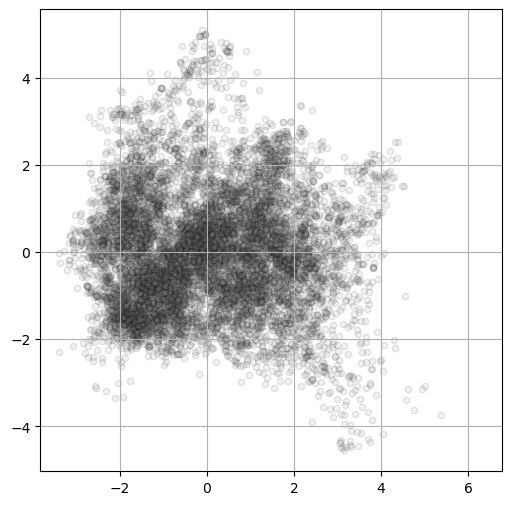

In [69]:
fig, ax = plt.subplots(figsize=(6,6))

points = ax.scatter(df_embed['pcaX'], df_embed['pcaY'], edgecolors='k', 
                    # marker='o', c='k', alpha=0.5,
                    marker='o', c='gray', alpha=0.1,
                    s=20)

ax.axis('square')
ax.grid(True)

# plt.savefig(resultsPath+'PCA_clusters_nolabels.png', dpi=300)

### plot reduced features colored by domains

In [70]:
Xpos = pcaFit.transform(df_posX.to_numpy())
Xneg = pcaFit.transform(df_negX.to_numpy())

XgeoT = pcaFit.transform(df_geoTX[df_geoTInfo['target']>xQuantile])

/home/srbrown/mambaforge/envs/pytorchGeo/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


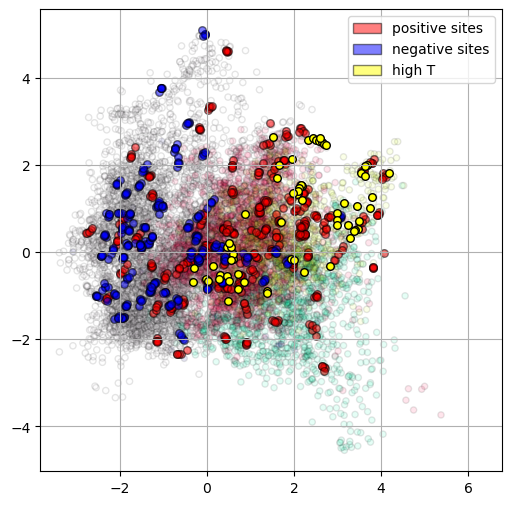

In [71]:
fig, ax = plt.subplots(figsize=(6,6))

points = ax.scatter(df_embed['pcaX'], df_embed['pcaY'], edgecolors='k', 
                    # marker='o', c='k', alpha=0.5,
                    marker='o', c=ysample, alpha=0.1,
                    s=20, cmap='gist_ncar')

points0 = ax.scatter(Xpos[:,0], Xpos[:,1], edgecolors='k', 
                    marker='o', c='r', alpha=0.5,
                    s=30)

points1 = ax.scatter(Xneg[:,0], Xneg[:,1], edgecolors='k', 
                    marker='o', c='b', alpha=0.5,
                    s=30)

points2 = ax.scatter(XgeoT[:,0], XgeoT[:,1], edgecolors='k', 
                    marker='o', c='yellow', alpha=1,
                    s=30)

ax.axis('square')
ax.grid(True)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(facecolor='red', alpha=0.5, edgecolor='k', label='positive sites')
blue_patch = mpatches.Patch(facecolor='blue', alpha=0.5, edgecolor='k', label='negative sites')
yellow_patch = mpatches.Patch(facecolor='yellow', alpha=0.5, edgecolor='k', label='high T')

plt.legend(handles=[red_patch, blue_patch, yellow_patch])

plt.savefig(resultsPath+'geochemT_PCA_clusters.png', dpi=300)


## UMAP

In [72]:
import umap as UMAP

/home/srbrown/mambaforge/envs/pytorchGeo/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/srbrown/mambaforge/envs/pytorchGeo/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/srbrown/mambaforge/envs/pytorchGeo/lib/python3.11/si

In [73]:
umap = UMAP.UMAP(random_state=42, 
                    min_dist=0.01, 
                    n_neighbors=600)

umapFit = umap.fit(Xsample.copy())

embedX = umapFit.transform(Xsample.copy())
                            
embedX.shape

(10558, 2)

In [74]:
df_embed['umapX'] = embedX[:,0]
df_embed['umapY'] = embedX[:,1]

In [75]:
Xpos = umapFit.transform(df_posX.to_numpy())
Xneg = umapFit.transform(df_negX.to_numpy())

XgeoT = umapFit.transform(df_geoTX[df_geoTInfo['target']>xQuantile])

### plot reduced features and color by domains and add training sites
### ... goal is to have reduced feature space that embodies all training sites

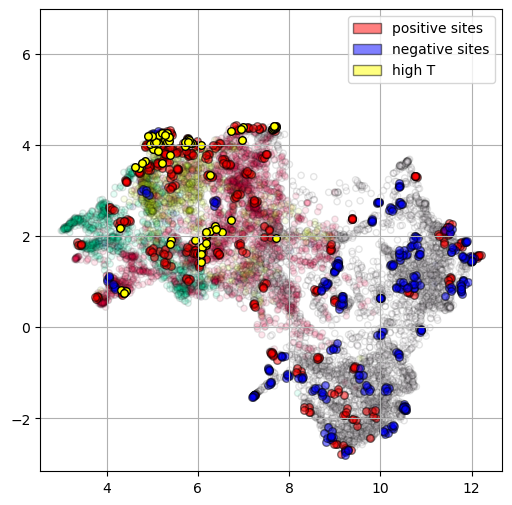

In [76]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

points = ax.scatter(df_embed['umapX'], df_embed['umapY'], edgecolors='k', 
                    marker='o', c=ysample, alpha=0.1,
                    # marker='o', c='deepskyblue',
                    s=20, cmap="gist_ncar")

points0 = ax.scatter(Xpos[:,0], Xpos[:,1], edgecolors='k', 
                    marker='o', c='r', alpha=0.5,
                    s=30)

points1 = ax.scatter(Xneg[:,0], Xneg[:,1], edgecolors='k', 
                    marker='o', c='b', alpha=0.5,
                    s=30)

points2 = ax.scatter(XgeoT[:,0], XgeoT[:,1], edgecolors='k', 
                    marker='o', c='yellow', alpha=1,
                    s=30)

ax.axis('square')
ax.grid(True)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(facecolor='red', alpha=0.5, edgecolor='k', label='positive sites')
blue_patch = mpatches.Patch(facecolor='blue', alpha=0.5, edgecolor='k', label='negative sites')
yellow_patch = mpatches.Patch(facecolor='yellow', alpha=0.5, edgecolor='k', label='high T')

plt.legend(handles=[red_patch, blue_patch, yellow_patch])

plt.savefig(resultsPath+'geochemT_umap_clusters.png', dpi=300)


In [77]:
# xxx

## k-means clustering

In [78]:
from sklearn.cluster import KMeans

In [79]:
model = KMeans(n_clusters=6, random_state=42, n_init='auto')

In [80]:
# Xk = df_embed[['pcaX', 'pcaY']].copy()
Xk = df_embed[['umapX', 'umapY']].copy()

labels_true = ysample.copy()
# labels_true = df_embed['y'].copy()

In [81]:
model.fit(Xk)

KMeans(n_clusters=6, n_init='auto', random_state=42)

In [82]:
model.predict(Xk[:10])

array([2, 2, 0, 4, 5, 1, 0, 1, 4, 1], dtype=int32)

In [83]:
centroids = model.cluster_centers_
centroids

array([[ 6.301283  ,  3.5185528 ],
       [10.834451  ,  1.4945111 ],
       [ 9.648718  , -1.5765597 ],
       [ 7.348365  ,  1.787716  ],
       [ 4.6280265 ,  1.8621181 ],
       [ 8.44556   , -0.03174281]], dtype=float32)

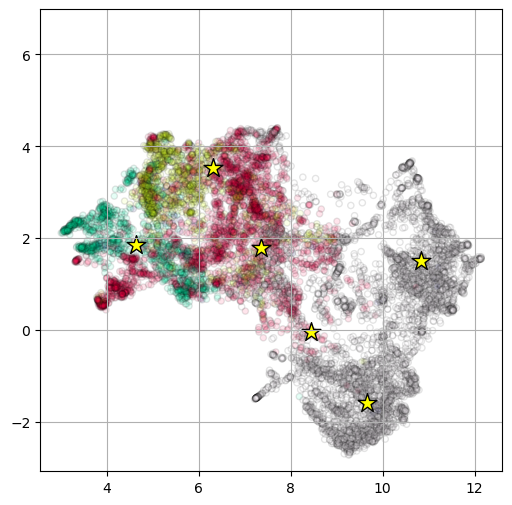

In [84]:
fig, ax = plt.subplots(figsize=(6,6))

# points = ax.scatter(df_embed['umapX'], df_embed['umapY'], edgecolors='k', 
points = ax.scatter(Xk.iloc[:,0], Xk.iloc[:,1], edgecolors='k', 
                    marker='o', c=ysample, alpha=0.1,
                    # marker='o', c='gray', alpha=0.1,
                    # marker='o', c=df_embed['y'], alpha=0.7,
#                     marker='o', c='deepskyblue',
                    s=20, cmap="gist_ncar")

ax.axis('square')
ax.grid(True)

ax.scatter(centroids[:,0], centroids[:,1], 
           edgecolors='k', marker='*',
           s=200, color='yellow')

### can use model.predict(Xk) or model.labels_ to see which cluster each point belongs to and change the symbol or color to mark them

In [85]:
model.predict(Xk)

array([2, 2, 0, ..., 2, 4, 2], dtype=int32)

### Bayesian Gaussian Mixture

In [86]:
from sklearn.mixture import BayesianGaussianMixture

In [87]:
# Xk = df_embed[['pcaX', 'pcaY']].copy()
Xk = df_embed[['umapX', 'umapY']].copy()

labels_true = ysample.copy()
# labels_true = df_embed['y'].copy()

In [88]:
model = BayesianGaussianMixture(n_components=6, random_state=42, max_iter=500)

In [89]:
model.fit(Xk)

BayesianGaussianMixture(max_iter=500, n_components=6, random_state=42)

In [90]:
preds = model.predict(Xk)
preds = pd.DataFrame(preds)
preds.index = Xk.index

In [91]:
preds.columns = ['clusters']

In [92]:
probs = model.predict_proba(Xk)
probs = pd.DataFrame(probs)
probs.index = Xk.index

In [93]:
cols = []
for c in probs.columns:
    cols.append('p'+str(c))
probs.columns = cols

In [94]:
BGMM = Xk.iloc[:,0:2].copy()
BGMM = pd.concat([BGMM, preds], axis=1)
BGMM = pd.concat([BGMM, probs], axis=1)

In [95]:
means = model.means_

In [96]:
covars = model.covariances_

In [97]:
weights = model.weights_

In [98]:
import matplotlib as mpl

def plot_ellipses(ax, alphas, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], 
                                  width=eig_vals[0], 
                                  height=eig_vals[1],
                                  angle=180+angle, 
                                  edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(alphas[n])
        # ell.set_facecolor('#56B4E9')
        ell.set_facecolor('gray')
        ellArtist = ax.add_artist(ell)
        ellArtist.set_zorder(0)

In [99]:
# centroids = centroids[(1,2),:]

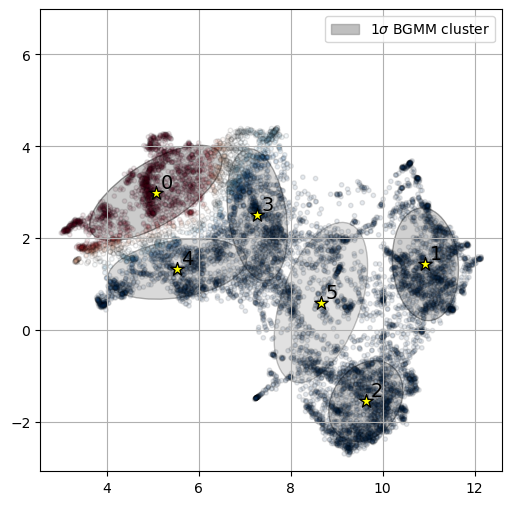

In [100]:
fig, ax = plt.subplots(figsize=(6,6))

nSigma = 1
alphas = 2*weights

plot_ellipses(ax, alphas, means, nSigma*covars)

pointsp = ax.scatter(Xk.iloc[:,0], Xk.iloc[:,1], edgecolors='k', 
                    # marker='o', c=ysample, alpha=0.1,
                    marker='o', c=BGMM['p0'], alpha=0.1,
                    # marker='o', c=BGMM['clusters'], alpha=0.1,
#                     marker='o', c='deepskyblue',
                    # s=10, cmap="gist_ncar")
                    s=10, cmap="RdBu_r")

ax.axis('square')
ax.grid(True)

ax.scatter(means[:,0], means[:,1], 
           edgecolors='k', marker='*',
           s=100, color='yellow')

for i in range(means.shape[0]):
    plt.text(means[i,0]+0.1,means[i,1]+0.1, str(i), fontsize=14, fontweight='roman', color='k')

g_patch = mpatches.Patch(color='g', label='paleo', alpha=0.5)
b_patch = mpatches.Patch(color='blue', label='neg', alpha=0.5)
r_patch = mpatches.Patch(color='red', label='pos', alpha=0.5)
gray_patch = mpatches.Patch(color='gray', label=str(nSigma)+'$\sigma$ BGMM cluster', alpha=0.5)

plt.legend(handles=[gray_patch])

In [101]:
dfRC = dfInfo.loc[BGMM.index]

dfRC = dfRC[['row', 'column']]

In [102]:
BGMM = pd.concat([BGMM, dfRC], axis=1)

In [103]:
subBGMM0 = BGMM[BGMM['clusters']==0]
subBGMM1 = BGMM[BGMM['clusters']==1]
subBGMM2 = BGMM[BGMM['clusters']==2]
subBGMM3 = BGMM[BGMM['clusters']==3]
subBGMM4 = BGMM[BGMM['clusters']==4]
subBGMM5 = BGMM[BGMM['clusters']==5]

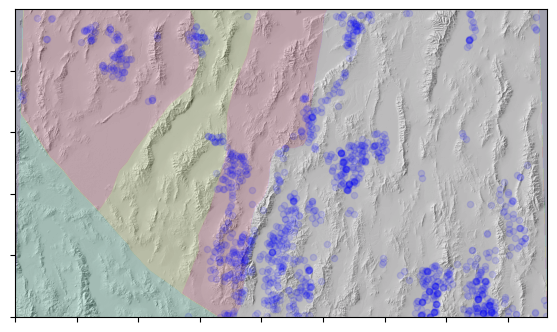

In [104]:
fig, ax = plt.subplots(figsize=(12,4))

ax.imshow(hill, cmap='gray', origin='lower')
ax.imshow(domain, cmap='gist_ncar', alpha=0.1, origin='lower')

ix = subBGMM5['column'].values
iy = subBGMM5['row'].values
c = subBGMM5['clusters']

ax.scatter(ix,iy, edgecolors=None, 
           marker='o', c='blue', alpha=0.1,
           # s=50, cmap="coolwarm")
           s=20)

ax.set(xticklabels=[]);
ax.set(yticklabels=[]);

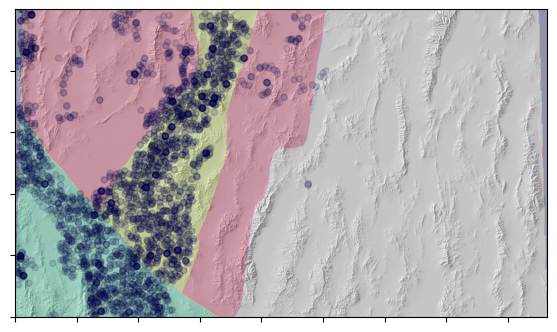

In [105]:
fig, ax = plt.subplots(figsize=(10,4))

cluster = 0

ix = BGMM['column'].values
iy = BGMM['row'].values
# c = np.exp(BGMM['p5'])
c = BGMM['clusters']
a = BGMM['p'+str(cluster)].copy()

a[a<0.5] = 0.0
a /= 5

ax.scatter(ix,iy, edgecolors='k', 
           marker='o', c=c, alpha=a,
           # s=20, cmap="Blues")
           s=20, cmap='gist_ncar')
           # s=20, cmap='RdBu_r')

ax.imshow(hill, cmap='gray', alpha=0.95, origin='lower')
ax.imshow(domain, cmap='gist_ncar', alpha=0.2, origin='lower')

ax.set(xticklabels=[]);
ax.set(yticklabels=[]);

# scikits-learn gaussian processes regression

In [106]:
# xxx

## Here define regression data set

In [107]:
problem = 'geochemistry temperature'

In [108]:
X = df_geoTX
y = df_geoTy

In [109]:
inferX0 = umapFit.transform(X.copy().to_numpy())

### fit all features or only the reduced (e.g. UMAP) features

In [110]:
# fit reduced features
# XtrainR = inferX0

# fit all features
XtrainR = X.copy()

ytrainR = y.copy()

In [111]:
XtrainR.shape

(669, 10)

In [112]:
ytrainR.shape

(669,)

Text(0.5, 1.0, '      in umap reduced dimensions')

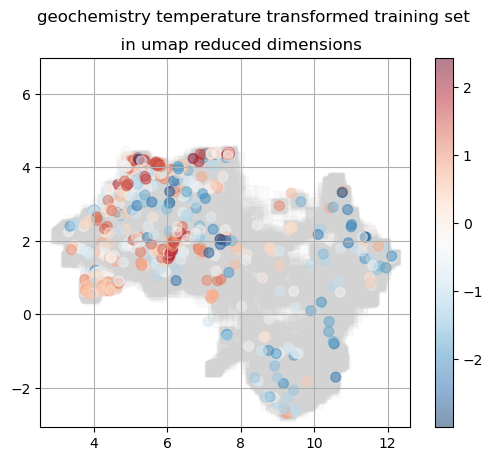

In [113]:
plt.scatter(df_embed['umapX'], df_embed['umapY'], edgecolors=None, 
                    marker='s', c='lightgray', alpha=0.1,
                    s=100)

plt.scatter(inferX0[:,0], inferX0[:,1], edgecolors=None, 
                    # marker='o', c=ytrain, alpha=0.1,
                    marker='o', c=ytrainR, alpha=0.5,
                    # marker='o', c='deepskyblue',
                    # s=20, cmap="gist_ncar")
                    s=50, cmap="RdBu_r")


plt.axis('square')
plt.grid(True)

plt.colorbar()

plt.suptitle(problem+' transformed training set')
plt.title('      in umap reduced dimensions')


## guess of kernel scale parameter

In [114]:
s = np.std(ytrainR) / (ytrainR.max()-ytrainR.min())

s**2

0.03588342839662761

In [115]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, DotProduct, WhiteKernel

# kernel = DotProduct() + WhiteKernel()

# kernel = ConstantKernel(0.1, (0.01, 10.0)) * (
#     DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 3
# )

# )


# This works with 10 features reduced to 2 umap
# kernel = 10.0 * RBF(length_scale=1, length_scale_bounds=(0.1, 1)) + \
#                 WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-5, 5e3))

# this works with 9 features reduced to 2 umap
# kernel = 10.0 * RBF(length_scale=0.3, length_scale_bounds=(0.1, 0.5)) + \
#                 WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-5, 5e3))

# this works with 10 features
# kernel = 10.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + \
#                  WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

kernel = ConstantKernel(s**2, constant_value_bounds="fixed") * \
         RBF(length_scale=1.5, length_scale_bounds="fixed")+ \
         WhiteKernel(noise_level=0.01, noise_level_bounds="fixed")
         # WhiteKernel(noise_level=0.001, noise_level_bounds="fixed")

        # WhiteKernel(noise_level=0.001, noise_level_bounds="fixed")
         # WhiteKernel(noise_level=0.00001, noise_level_bounds="fixed")
         # RBF(length_scale=2, length_scale_bounds="fixed")+ \
         # WhiteKernel(noise_level=0.5, noise_level_bounds="fixed")
         # WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-5, 1e1))

gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(XtrainR, ytrainR)

gpr.score(XtrainR, ytrainR)

# gpr.predict(Xsample[:2,:], return_std=True)

0.8079950996437977

### depending on if we fit all features or only the reduced (e.g. UMAP) features

In [116]:
# ypred, ystd = gpr.predict(df_embed[['umapX','umapY']].to_numpy(), return_std=True)
# ypred, ystd = gpr.predict(df_embed[['pcaX','pcaY']].to_numpy(), return_std=True)

ypred, ystd = gpr.predict(Xsample, return_std=True)

In [117]:
ypred.shape

(10558,)

In [118]:
# ypreds = gpr.sample_y(df_embed[['umapX','umapY']].to_numpy())

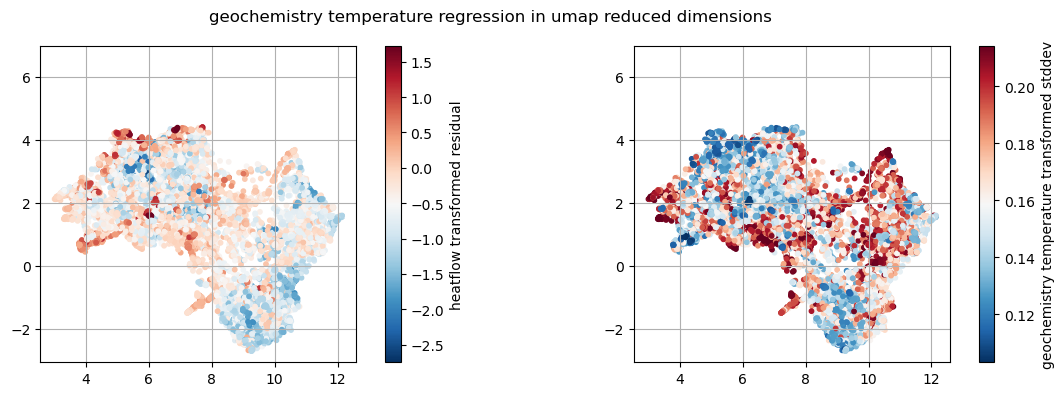

In [119]:
fig,ax = plt.subplots(figsize=(12,4), nrows=1, ncols=2)

# plt.scatter(df_embed['pcaX'], df_embed['pcaY'], edgecolors=None, 
p0 = ax[0].scatter(df_embed['umapX'], df_embed['umapY'], edgecolors=None, 
                    marker='o', c=ypred, alpha=1,
                    # s=10, cmap="RdBu_r")
                    s=10, cmap="RdBu_r")
                    # s=20, cmap="gist_ncar")
                    # s=20, cmap="coolwarm")
    
ax[0].axis('square')
ax[0].grid(True)
plt.colorbar(p0,label='heatflow transformed residual')


# plt.scatter(df_embed['pcaX'], df_embed['pcaY'], edgecolors=None, 
p1 = ax[1].scatter(df_embed['umapX'], df_embed['umapY'], edgecolors=None, 
                    marker='o', c=ystd, alpha=1,
                    s=10, cmap="RdBu_r")
                    # s=20, cmap="gist_ncar")
                    # s=20, cmap="coolwarm")

ax[1].axis('square')
ax[1].grid(True)
plt.colorbar(p1,label=problem+' transformed stddev')

plt.suptitle(problem+' regression in umap reduced dimensions');

plt.tight_layout()

### invert transformed values

In [120]:
predInverse = pt_geochemT.inverse_transform(ypred.reshape(-1,1))
# stdInv = pt_heatflow.inverse_transform(ystd.reshape(-1,1))

df_regression = dfRC.copy()
df_regression['predInverse'] = predInverse
df_regression['predTransformed'] = ypred
df_regression['stdTransformed'] = ystd

# df_regression['stdInv'] = stdInv

In [121]:
from sklearn.neighbors import KernelDensity

bins = np.linspace(-5, 5, 50)
X_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]

kde = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(ytrainR.to_numpy().reshape(-1, 1))
log_dens = kde.score_samples(X_plot)

kde_pred = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(ypred.reshape(-1, 1))
log_dens_pred = kde_pred.score_samples(X_plot)

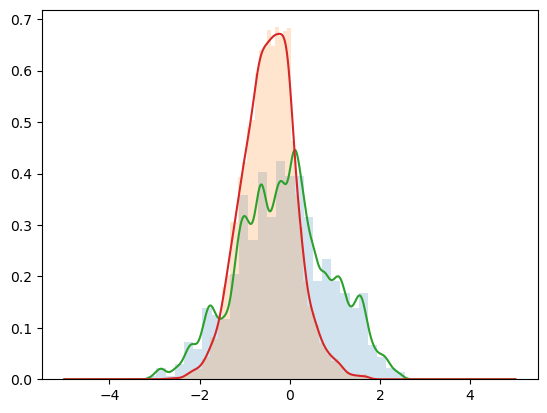

In [122]:
plt.hist(ytrainR, bins=bins, density=True, alpha=0.2);
plt.hist(ypred, 50, density=True, alpha=0.2);
plt.plot(X_plot, np.exp(log_dens))
plt.plot(X_plot, np.exp(log_dens_pred))
# plt.plot(X_plot, (log_dens))
# plt.plot(X_plot, (log_dens_pred))

# plt.ylim(0,1)

## KL divergence

https://machinelearningmastery.com/divergence-between-probability-distributions/

In [123]:
from scipy.special import rel_entr, kl_div

# define distributions
p = np.exp(log_dens)
q = np.exp(log_dens_pred)

# calculate (P || Q)
kl_pq = rel_entr(p, q)
print('KL(P || Q): %.3f nats' % np.sum(kl_pq))
# calculate (Q || P)
kl_qp = rel_entr(q, p)
print('KL(Q || P): %.3f nats' % np.sum(kl_qp))

# calculate (P || Q)
kl = kl_div(p, q)
print('KL(P || Q): %.3f nats' % np.sum(kl))
# calculate (Q || P)
kl = kl_div(q, p)
print('KL(Q || P): %.3f nats' % np.sum(kl))


# calculate the kl divergence
def kl_divergence(p, q):
    s = np.sum(p * np.log2(p/q))
    return s               
    # return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

kl_pq = rel_entr(p, q)
print('KL(P || Q): %.3f nats' % np.sum(kl_pq))
# calculate (Q || P)
kl_qp = rel_entr(q, p)
print('KL(Q || P): %.3f nats' % np.sum(kl_qp))


# calculate the js divergence
def js_divergence(p, q):
 m = 0.5 * (p + q)
 return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

# calculate JS(P || Q)
js_pq = js_divergence(p, q)
print('JS(P || Q) divergence: %.3f bits' % js_pq)
print('JS(P || Q) distance: %.3f' % np.sqrt(js_pq))

# calculate the jensen-shannon distance metric
from scipy.spatial.distance import jensenshannon
# calculate JS(P || Q)
js_pq = jensenshannon(p, q, base=2)
print('JS(P || Q) Distance: %.3f' % js_pq)
# calculate JS(Q || P)
js_qp = jensenshannon(q, p, base=2)
print('JS(Q || P) Distance: %.3f' % js_qp)

KL(P || Q): 66.467 nats
KL(Q || P): 27.427 nats
KL(P || Q): 66.467 nats
KL(Q || P): 27.427 nats
KL(P || Q): 66.467 nats
KL(Q || P): 27.427 nats
JS(P || Q) divergence: 11.349 bits
JS(P || Q) distance: 3.369
JS(P || Q) Distance: 0.337
JS(Q || P) Distance: 0.337


### plot maps of predicted values for our PCA/UMAP random samples + training sites

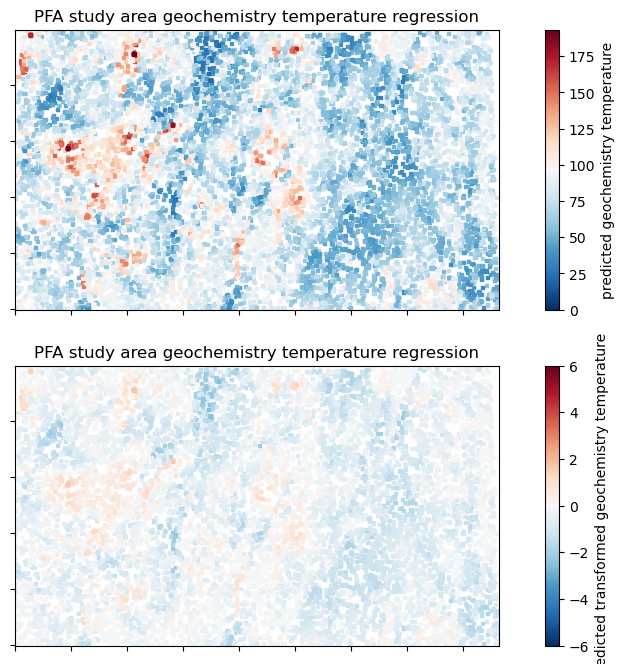

In [124]:
fig, ax = plt.subplots(2,1, figsize=(12,8))

##############################################################
ix = df_regression['column'].values
iy = df_regression['row'].values
c = df_regression['predInverse']

a = 1

ax[0].imshow(hill, cmap='gray', alpha=0.01, origin='lower')
# ax.imshow(domain, cmap='gray', alpha=1, origin='lower')

pts = ax[0].scatter(ix,iy, edgecolors=None, 
           marker='s', c=c, alpha=a,
           s=5, cmap='RdBu_r', vmin=0, vmax=None)
           # s=5, cmap='RdBu_r', vmin=-350, vmax=350)
           # s=5, cmap='RdBu_r', vmin=-350, vmax=350)

# ax.imshow(domain, cmap='gray', alpha=0.8, origin='lower')

ax[0].set(xticklabels=[]);
ax[0].set(yticklabels=[]);

ax[0].set_title('PFA study area '+problem+' regression')

plt.colorbar(pts, label='predicted '+problem)

##############################################################
ix = df_regression['column'].values
iy = df_regression['row'].values
c = df_regression['predTransformed']

a = 1

ax[1].imshow(hill, cmap='gray', alpha=0.01, origin='lower')
# ax.imshow(domain, cmap='gray', alpha=1, origin='lower')

pts = ax[1].scatter(ix,iy, edgecolors=None, 
           marker='s', c=c, alpha=a,
           # s=5, cmap='RdBu_r', vmin=-200, vmax=200)
           s=5, cmap='RdBu_r', vmin=-6, vmax=6)

# ax.imshow(domain, cmap='gray', alpha=0.8, origin='lower')

ax[1].set(xticklabels=[]);
ax[1].set(yticklabels=[]);

ax[1].set_title('PFA study area '+problem+' regression')

plt.colorbar(pts, label='predicted transformed '+problem)

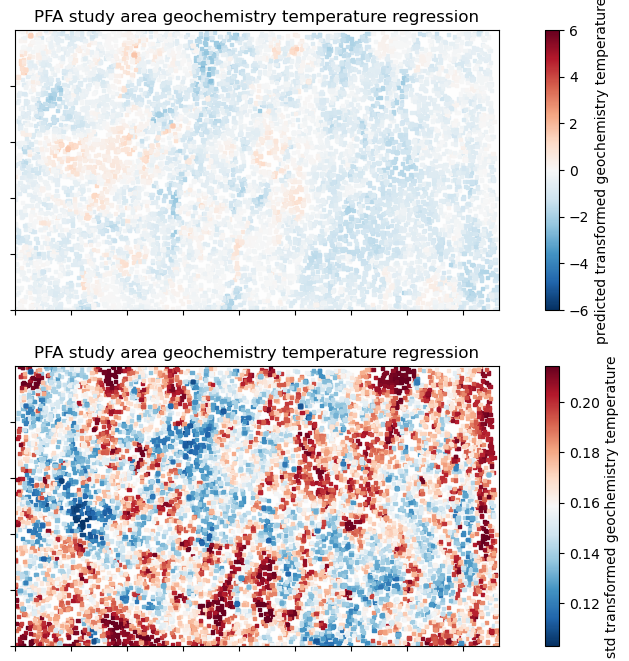

In [125]:
fig, ax = plt.subplots(2,1, figsize=(12,8))

##############################################################
ix = df_regression['column'].values
iy = df_regression['row'].values
c = df_regression['predTransformed']

a = 1

ax[0].imshow(hill, cmap='gray', alpha=0.01, origin='lower')
# ax.imshow(domain, cmap='gray', alpha=1, origin='lower')

pts = ax[0].scatter(ix,iy, edgecolors=None, 
           marker='s', c=c, alpha=a,
           # s=5, cmap='RdGy_r')
           s=5, cmap='RdBu_r', vmin=-6, vmax=6)

# ax.imshow(domain, cmap='gray', alpha=0.8, origin='lower')

ax[0].set(xticklabels=[]);
ax[0].set(yticklabels=[]);

ax[0].set_title('PFA study area '+problem+' regression')

plt.colorbar(pts, label='predicted transformed '+problem)

##############################################################
ix = df_regression['column'].values
iy = df_regression['row'].values
c = df_regression['stdTransformed']
# c = c-c.mean()
# c = df_regression['stdTransformed']/(np.mean(df_regression['predTransformed']))
  
a = 1

ax[1].imshow(hill, cmap='gray', alpha=0.01, origin='lower')
# ax.imshow(domain, cmap='gray', alpha=1, origin='lower')

pts = ax[1].scatter(ix,iy, edgecolors=None, 
           marker='s', c=c, alpha=a,
           # s=5, cmap='Blues_r', vmin=0, vmax=0.15)
           # s=5, cmap='coolwarm', vmin=0, vmax=0.15)
           # s=5, cmap='Blues', vmin=0, vmax=0.1)
           # s=5, cmap='Blues')
           s=5, cmap='RdBu_r')
           # s=5, cmap='Reds', vmin=0, vmax=1)
           # s=5, cmap='RdBu_r', vmin=-0.05, vmax=0.05)
           # s=5, cmap='coolwarm')

           # s=5, cmap='RdBu_r', vmin=0, vmax=0.1)

# ax.imshow(domain, cmap='gray', alpha=0.8, origin='lower')

ax[1].set(xticklabels=[]);
ax[1].set(yticklabels=[]);

ax[1].set_title('PFA study area '+problem+' regression')

plt.colorbar(pts, label='std transformed '+problem)


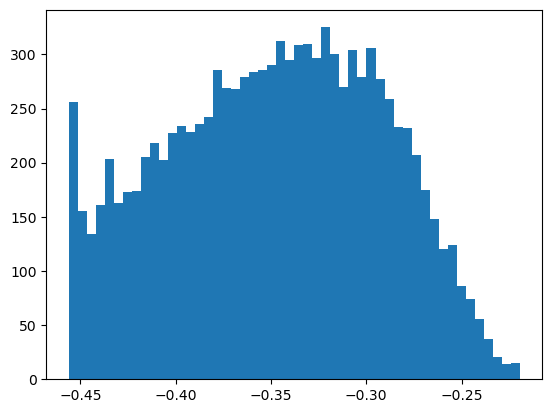

In [126]:
plt.hist(df_regression['stdTransformed']/np.mean(df_regression['predTransformed']),50);
# plt.hist(np.abs(df_regression['stdTransformed']),50);
# plt.hist(np.abs(df_regression['predTransformed']),50);

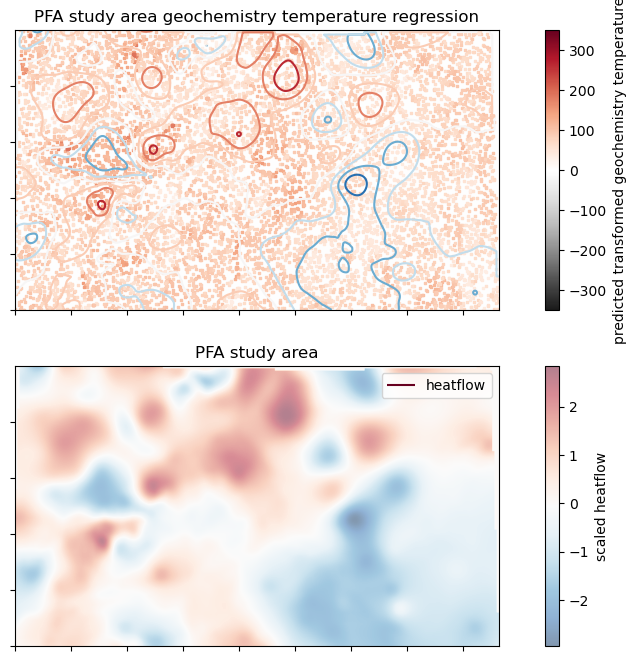

In [127]:
fig, ax = plt.subplots(2,1, figsize=(12,8))

#################################################################
ix = df_regression['column'].values
iy = df_regression['row'].values
c = df_regression['predInverse']

a = 1

ax[0].imshow(hill, cmap='gray', alpha=0.01, origin='lower')
# ax.imshow(domain, cmap='gray', alpha=1, origin='lower')

pts = ax[0].scatter(ix,iy, edgecolors=None, 
           marker='s', c=c, alpha=a,
           # s=5, cmap='RdGy_r', vmin=-3, vmax=3)
           s=2, cmap='RdGy_r', vmin=-350, vmax=350)

c = ax[0].contour(hfMap, cmap='RdBu_r', alpha=1, origin='lower')

ax[0].set(xticklabels=[]);
ax[0].set(yticklabels=[]);

ax[0].set_title('PFA study area '+problem+' regression')

plt.colorbar(pts, label='predicted transformed '+problem)

# plt.clabel(c, inline=1, fontsize=10)
h,l = c.legend_elements()
plt.legend([h[-1]], ['heatflow'])

#################################################################
# plt.subplot(122)
c = ax[1].imshow(hfMap, cmap='RdBu_r', alpha=0.5, origin='lower')

ax[1].set(xticklabels=[]);
ax[1].set(yticklabels=[]);

ax[1].set_title('PFA study area')

plt.colorbar(c, label='scaled heatflow')

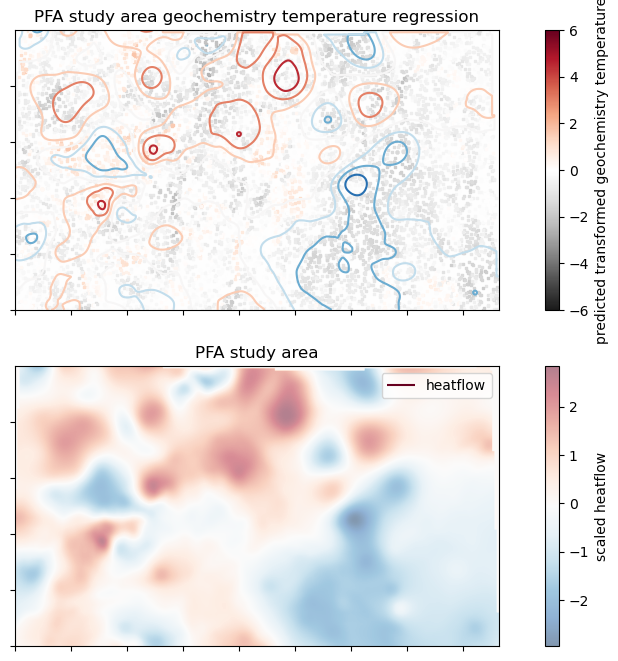

In [128]:
fig, ax = plt.subplots(2,1, figsize=(12,8))

#################################################################
ix = df_regression['column'].values
iy = df_regression['row'].values
c = df_regression['predTransformed']

a = 1

ax[0].imshow(hill, cmap='gray', alpha=0.01, origin='lower')
# ax.imshow(domain, cmap='gray', alpha=1, origin='lower')

pts = ax[0].scatter(ix,iy, edgecolors=None, 
           marker='s', c=c, alpha=a,
           # s=5, cmap='RdGy_r', vmin=-3, vmax=3)
           s=2, cmap='RdGy_r', vmin=-6, vmax=6)
           # s=5, cmap='RdGy_r', vmin=-350, vmax=350)

c = ax[0].contour(hfMap, cmap='RdBu_r', alpha=1, origin='lower')

ax[0].set(xticklabels=[]);
ax[0].set(yticklabels=[]);

ax[0].set_title('PFA study area '+problem+' regression')

plt.colorbar(pts, label='predicted transformed '+problem)

# plt.clabel(c, inline=1, fontsize=10)
h,l = c.legend_elements()
plt.legend([h[-1]], ['heatflow'])

#################################################################
# plt.subplot(122)
c = ax[1].imshow(hfMap, cmap='RdBu_r', alpha=0.5, origin='lower')

ax[1].set(xticklabels=[]);
ax[1].set(yticklabels=[]);

ax[1].set_title('PFA study area')

plt.colorbar(c, label='scaled heatflow')

In [129]:
# xxx

## prediction for every pixel
### use pytorch dataloaders for convenience

In [130]:
df_Xall.columns

Index(['QuaternaryFaultTraces', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GeodeticStrainRate', 'QuaternarySlipRate',
       'FaultRecency', 'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow',
       'DEM-30m'],
      dtype='object')

In [131]:
Xall = df_Xall.copy()
Xall = Xall.to_numpy()

columns = df_Xall.columns

## develop image by sampling

In [132]:
###########################################
t0 = time.time()
###########################################

# inference in batches
eval_loader = DataLoader(Xall, shuffle=False, 
                         batch_size=512, drop_last=False)

# yResultMean = []
yResult = []
yResultStd = []
yResultInv = []
yResultStdInv = []

# break image into batches
for features in tqdm(eval_loader):

    # batch of features
    Xsample = pd.DataFrame(features.numpy(), columns=columns)    

    # can directly get mean and stddev of GP
    #   the mean is exact and should be used, but stddev seems truncated 
    #   ... will use stddev of samples instead
    # ypredMean, ypredStd = gpr.predict(Xsample, return_std=True)
    ypredMean = gpr.predict(Xsample, return_std=False)
    ypredMean_shape = ypredMean.shape

    # sample the Gaussian Process for each pixel in a batch
    ###########################################
    ysample = gpr.sample_y(Xsample, n_samples=1024)
    sample_shape = ysample.shape    

    ypredMeanInverse = pt_geochemT.inverse_transform(ypredMean.reshape(-1,1))
    ypredMeanInverse = ypredMeanInverse.reshape(ypredMean_shape)
    
    ysampleInverse = pt_geochemT.inverse_transform(ysample.reshape(-1,1))
    ysampleInverse = ysampleInverse.reshape(sample_shape)
    ###########################################

    # compute the statistics for each pixel in a batch
    ###########################################
    ypred = ypredMean
    # ypred = np.mean(ysample, axis=1)
    ystd = np.std(ysample, axis=1)
    
    ypredInverse = ypredMeanInverse
    # ypredInverse = np.mean(ysampleInverse, axis=1)
    ystdInverse = np.std(ysampleInverse, axis=1)
    ###########################################
    
    # append the batches together
    ###########################################
    # ypredMean = Tensor(ypredMean).squeeze()
    ypred = Tensor(ypred).squeeze()
    ystd = Tensor(ystd).squeeze()
    ypredInverse = Tensor(ypredInverse).squeeze()
    ystdInverse = Tensor(ystdInverse).squeeze()

    # yResultMean.append(ypredMean)
    yResult.append(ypred)
    yResultStd.append(ystd)
    yResultInv.append(ypredInverse)
    yResultStdInv.append(ystdInverse)
    ###########################################

# reassemble the image
###########################################
# yResultMean = torch.cat(yResultMean, dim=0)
yResult = torch.cat(yResult, dim=0)
yResultStd = torch.cat(yResultStd, dim=0)
yResultInv = torch.cat(yResultInv, dim=0)
yResultStdInv = torch.cat(yResultStdInv, dim=0)
###########################################


###########################################
print ('Inference time = ', time.time()-t0)
###########################################

print (yResult.shape)

  0%|          | 0/3375 [00:00<?, ?it/s]

Inference time =  363.6172215938568
torch.Size([1728000])


## plot results

In [133]:
# img = yResult.numpy().reshape(1000,-1)
img = yResultInv.numpy().reshape(1000,-1)
img = np.flipud(img)

# imgstd = yResultStd.numpy().reshape(1000,-1)
imgstd = yResultStdInv.numpy().reshape(1000,-1)
imgstd = np.flipud(imgstd)

In [134]:
img.shape

(1000, 1728)

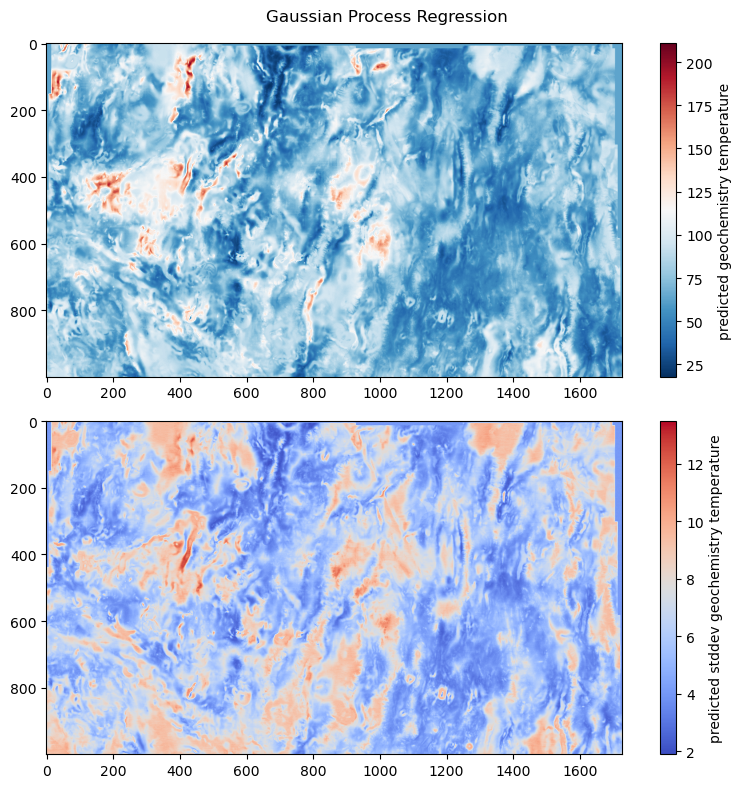

In [135]:
fig, ax = plt.subplots(2,1, figsize=(8,8))

plt.suptitle('Gaussian Process Regression')
# plt.suptitle('GP sampled')
# plt.suptitle('GP inverse cheat')

# plt.imshow(img, cmap='RdBu_r', vmin=0, vmax=None)
p0 = ax[0].imshow(img, cmap='RdBu_r')
plt.colorbar(p0, label='predicted '+problem) 
    
# p1 = ax[1].imshow(imgstd, cmap='RdBu_r')
p1 = ax[1].imshow(imgstd, cmap='coolwarm')
# p1 = ax[1].imshow(imgstd, cmap='RdBu_r', vmin=0, vmax=0.2)

# plt.colorbar(p1, label='predicted stddev transformed '+problem)
plt.colorbar(p1, label='predicted stddev '+problem)

plt.tight_layout()

# plt.savefig(resultsPath+'geochemT_transformed_regression_prediction_maps.png')
plt.savefig(resultsPath+'geochemT_invtransformed_regression_prediction_maps.png')

# plt.savefig('sampled_regression_prediction_maps.png')
# plt.savefig('GP_inverse_cheat_regression_prediction_maps.png')

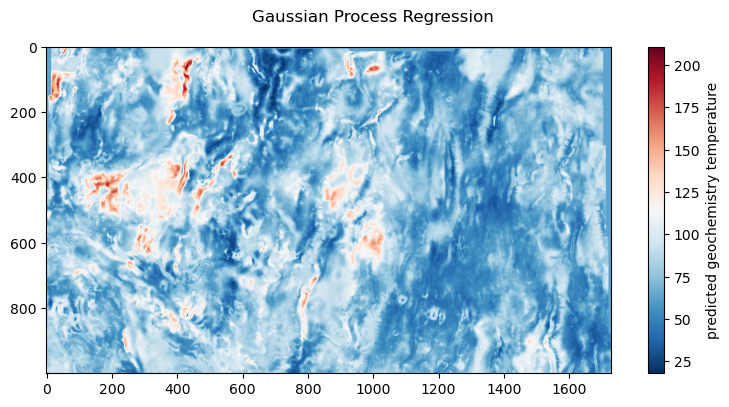

In [136]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plt.suptitle('Gaussian Process Regression')
# plt.suptitle('GP sampled')
# plt.suptitle('GP inverse cheat')

# plt.imshow(img, cmap='RdBu_r', vmin=0, vmax=None)
p0 = ax.imshow(img, cmap='RdBu_r')
plt.colorbar(p0, label='predicted '+problem) 
    
# # p1 = ax[1].imshow(imgstd, cmap='RdBu_r')
# p1 = ax[1].imshow(imgstd, cmap='coolwarm')
# # p1 = ax[1].imshow(imgstd, cmap='RdBu_r', vmin=0, vmax=0.2)

# # plt.colorbar(p1, label='predicted stddev transformed '+problem)
# plt.colorbar(p1, label='predicted stddev '+problem)

plt.tight_layout()

# plt.savefig(resultsPAth+'geochemT_transformed_regression_prediction_maps_0.png')
plt.savefig(resultsPath+'geochemT_invtransformed_regression_prediction_maps_0.png', dpi=300)

# plt.savefig('transformed_regression_prediction_maps.png')
# plt.savefig('sampled_regression_prediction_maps.png')
# plt.savefig('GP_inverse_cheat_regression_prediction_maps.png')

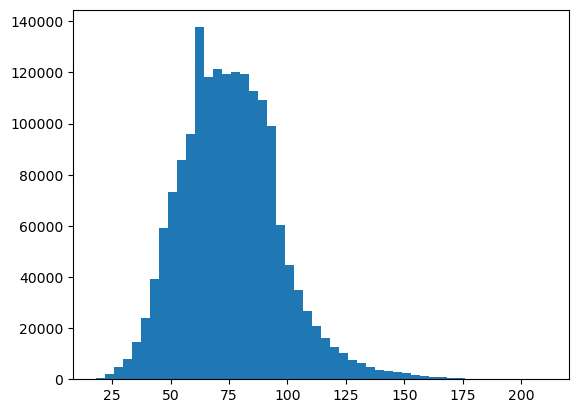

In [137]:
plt.hist(img.ravel(), 50);

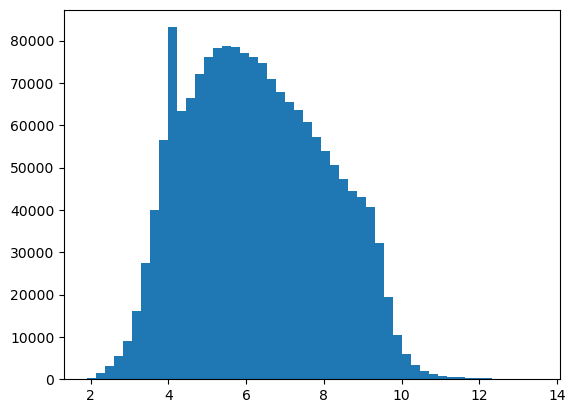

In [138]:
plt.hist(imgstd.ravel(), 50);

In [139]:
xxx

NameError: name 'xxx' is not defined

## save results to pickle file

In [140]:
frame = {'geoT_transformed':yResult, 'geoT_transformed_std':yResultStd,
         'geoT':yResultInv, 'geoT_std':yResultStdInv}

df_results = pd.DataFrame(frame)

In [141]:
df_results

geoT_transformed  geoT_transformed_std       geoT  geoT_std
0               -0.255892              0.206058  82.144310  8.332926
1               -0.227075              0.202836  83.310425  8.254005
2               -0.188338              0.199221  84.896484  8.223561
3               -0.121701              0.196881  87.675186  8.315298
4               -0.094044              0.199866  88.847343  8.514351
...                   ...                   ...        ...       ...
1727995         -0.768151              0.123224  63.301376  4.129768
1727996         -0.768151              0.118988  63.301376  3.978686
1727997         -0.768151              0.122926  63.301376  4.115812
1727998         -0.768151              0.121627  63.301376  4.077035
1727999         -0.768151              0.126903  63.301376  4.242006

[1728000 rows x 4 columns]

In [142]:
info_columns

['row', 'column', 'id_rc', 'X_83UTM11', 'Y_83UTM11', 'NullInfo', 'class']

In [143]:
dfInfo[info_columns[:-1]]

row  column       id_rc      X_83UTM11     Y_83UTM11   NullInfo
0          0.0     0.0        R1C1  286327.690182  4.258714e+06    notNull
1          0.0     1.0        R1C2  286577.690182  4.258714e+06    notNull
2          0.0     2.0        R1C3  286827.690182  4.258714e+06    notNull
3          0.0     3.0        R1C4  287077.690182  4.258714e+06    notNull
4          0.0     4.0        R1C5  287327.690182  4.258714e+06    notNull
...        ...     ...         ...            ...           ...        ...
1727995  999.0  1723.0  R1000C1724  717077.690182  4.508464e+06  nullValue
1727996  999.0  1724.0  R1000C1725  717327.690182  4.508464e+06  nullValue
1727997  999.0  1725.0  R1000C1726  717577.690182  4.508464e+06  nullValue
1727998  999.0  1726.0  R1000C1727  717827.690182  4.508464e+06  nullValue
1727999  999.0  1727.0  R1000C1728  718077.690182  4.508464e+06  nullValue

[1728000 rows x 6 columns]

In [144]:
df_HF_residual_GPRregression = pd.concat([dfInfo[info_columns[:-1]], df_results],axis=1)

In [145]:
results_dict = {'df_geoT_GPRegression':df_HF_residual_GPRregression,
                'df_XClasses':df_XClasses, 
                'df_infoClasses':df_infoClasses}

with open(resultsPath+'geochemT_GPRegression.pkl', 'wb') as handle:
    pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## check pickle file

In [146]:
with open(resultsPath+'geochemT_GPRegression.pkl', 'rb') as handle:
    b = pickle.load(handle)

b.keys()

dict_keys(['df_geoT_GPRegression', 'df_XClasses', 'df_infoClasses'])

In [147]:
b['df_geoT_GPRegression']

row  column       id_rc      X_83UTM11     Y_83UTM11   NullInfo  \
0          0.0     0.0        R1C1  286327.690182  4.258714e+06    notNull   
1          0.0     1.0        R1C2  286577.690182  4.258714e+06    notNull   
2          0.0     2.0        R1C3  286827.690182  4.258714e+06    notNull   
3          0.0     3.0        R1C4  287077.690182  4.258714e+06    notNull   
4          0.0     4.0        R1C5  287327.690182  4.258714e+06    notNull   
...        ...     ...         ...            ...           ...        ...   
1727995  999.0  1723.0  R1000C1724  717077.690182  4.508464e+06  nullValue   
1727996  999.0  1724.0  R1000C1725  717327.690182  4.508464e+06  nullValue   
1727997  999.0  1725.0  R1000C1726  717577.690182  4.508464e+06  nullValue   
1727998  999.0  1726.0  R1000C1727  717827.690182  4.508464e+06  nullValue   
1727999  999.0  1727.0  R1000C1728  718077.690182  4.508464e+06  nullValue   

         geoT_transformed  geoT_transformed_std       geoT  geoT_std  
0               -0.255892              0.206058  82.144310  8.332926  
1               -0.227075              0.202836  83.310425  8.254005  
2               -0.188338              0.199221  84.896484  8.223561  
3               -0.121701              0.196881  87.675186  8.315298  
4               -0.094044              0.199866  88.847343  8.514351  
...                   ...                   ...        ...       ...  
1727995         -0.768151              0.123224  63.301376  4.129768  
1727996         -0.768151              0.118988  63.301376  3.978686  
1727997         -0.768151              0.122926  63.301376  4.115812  
1727998         -0.768151              0.121627  63.301376  4.077035  
1727999         -0.768151              0.126903  63.301376  4.242006  

[1728000 rows x 10 columns]

In [148]:
b['df_geoT_GPRegression'].columns

Index(['row', 'column', 'id_rc', 'X_83UTM11', 'Y_83UTM11', 'NullInfo',
       'geoT_transformed', 'geoT_transformed_std', 'geoT', 'geoT_std'],
      dtype='object')

In [149]:
# df.to_hdf('HF_residual_GPRegression.h5', key='df_HF_residial_GPRegression', mode='w') 
# df_read = pd.read_hdf('HF_residual_GPRegression.h5', 'df_HF_residial_GPRegression')

In [150]:
xxx

NameError: name 'xxx' is not defined

# $\color{red}{\text{continue editing here}}$

# Explore some ways to optimize GP parameters

# cross validation

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, DotProduct, WhiteKernel

# kernel = DotProduct() + WhiteKernel()

# kernel = ConstantKernel(0.1, (0.01, 10.0)) * (
#     DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 3
# )

# )


# This works with 10 features reduced to 2 umap
# kernel = 10.0 * RBF(length_scale=1, length_scale_bounds=(0.1, 1)) + \
#                 WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-5, 5e3))

# this works with 9 features reduced to 2 umap
# kernel = 10.0 * RBF(length_scale=0.3, length_scale_bounds=(0.1, 0.5)) + \
#                 WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-5, 5e3))

# # this works with 10 features
# kernel = 10.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + \
#                  WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))


# gpr = GaussianProcessRegressor(kernel=kernel,
#         random_state=0).fit(XtrainR, ytrainR)

kernel = ConstantKernel(s**2, constant_value_bounds="fixed") * \
         RBF(length_scale=2, length_scale_bounds="fixed")+ \
         WhiteKernel(noise_level=0.5, noise_level_bounds=(1e-5, 1e1))

gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(XtrainR, ytrainR)

gpr.score(XtrainR, ytrainR)

# gpr.predict(Xsample[:2,:], return_std=True)

In [ ]:
# df_embed[['umapX','umapY']]

In [ ]:
# ypred, ystd = gpr.predict(df_embed[['umapX','umapY']].to_numpy(), return_std=True)
# ypred, ystd = gpr.predict(df_embed[['tsneX','tsneY']].to_numpy(), return_std=True)
# ypred, ystd = gpr.predict(df_embed[['pcaX','pcaY']].to_numpy(), return_std=True)

ypred, ystd = gpr.predict(Xsample, return_std=True)

In [ ]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=2)
# for train, test in kf.split(XtrainR):
#     print("%s %s" % (train, test))


In [ ]:
from sklearn.model_selection import ShuffleSplit

kernel = ConstantKernel(s**2, constant_value_bounds="fixed") * \
         RBF(length_scale=2, length_scale_bounds="fixed")+ \
         WhiteKernel(noise_level=0.5, noise_level_bounds="fixed")

gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0)

ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

scoresTrain = []
scoresTest = []
for train_index, test_index in ss.split(X):
    gpr.fit(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index])
    scoresTrain.append(gpr.score(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index]))
    scoresTest.append(gpr.score(XtrainR.iloc[test_index,:], ytrainR.iloc[test_index]))

print (np.mean(scoresTrain), np.mean(scoresTest))

# scores = []
# for train_index, test_index in ss.split(XtrainR):
#     gpr.fit(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index])
#     scores.append(gpr.score(XtrainR.iloc[test_index,:], ytrainR.iloc[test_index]))

# print (np.mean(scores))

# print(scores)

# gpr.fit(XtrainR, ytrainR)
# gpr.score(XtrainR, ytrainR)


In [ ]:
kernel

In [ ]:
from sklearn.model_selection import KFold

# # this works with 10 features
# kernel = 10.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + \
#                  WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

kernel = ConstantKernel(s**2, constant_value_bounds="fixed") * \
         RBF(length_scale=2, length_scale_bounds="fixed")+ \
         WhiteKernel(noise_level=0.5, noise_level_bounds="fixed")

gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0)

X = XtrainR
kf = KFold(n_splits=10)

scoresTrain = []
scoresTest = []
for train_index, test_index in kf.split(X):
    gpr.fit(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index])
    scoresTrain.append(gpr.score(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index]))
    scoresTest.append(gpr.score(XtrainR.iloc[test_index,:], ytrainR.iloc[test_index]))
    
    

print (np.mean(scoresTrain), np.mean(scoresTest))

# print(scores)


In [ ]:
from sklearn.model_selection import LeaveOneOut, LeavePOut

loo = LeaveOneOut()
# lpo = LeavePOut(10)

kernel = ConstantKernel(s**2, constant_value_bounds="fixed") * \
         RBF(length_scale=2, length_scale_bounds="fixed")+ \
         WhiteKernel(noise_level=0.5, noise_level_bounds="fixed")

gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0)

X = XtrainR

scoresTrain = []
scoresTest = []
for train_index, test_index in loo.split(X):
    gpr.fit(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index])   
    errorTrain = np.mean((gpr.predict(XtrainR.iloc[train_index,:]) - ytrainR.iloc[train_index])**2)
    errorTest  = np.mean((gpr.predict(XtrainR.iloc[test_index,:]) - ytrainR.iloc[test_index])**2)
    scoresTrain.append(errorTrain)
    scoresTest.append(errorTest)

print (np.mean(scoresTrain), np.mean(scoresTest))

# print(scores)


In [ ]:
parRange = [np.arange(1, 5, 2), np.arange(0.1, 2, 0.5)]
parRange[1].shape

## loop over parameters

In [ ]:
from sklearn.model_selection import KFold
import itertools


##################################################################
# include kl divergence as metric
##################################################################
from sklearn.neighbors import KernelDensity
bins = np.linspace(-5, 5, 50)
X_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]

from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
##################################################################

# parRange = [np.arange(1, 20, 2), np.arange(0.0, 1, 0.5)]
# parRange = [np.arange(1, 5, 1), np.logspace(-1,3,10)]
# parRange = [np.logspace(np.log10(1), np.log10(5), 10), np.logspace(-1,0,10)]
# parRange = [np.linspace(1, 5, 9), np.logspace(-1,0,10)]
# parRange = [np.linspace(1, 5, 5), np.logspace(-1,0,5)]
# parRange = [np.linspace(0.1, 10, 9), np.logspace(-1,1.2,10)]
parRange = [np.logspace(np.log10(0.2), np.log10(20), 10), np.logspace(-1,1.2,20)]
# parRange = [np.linspace(1, 5, 4),np.logspace(-1,0, 4)]

kernels = [ConstantKernel(s**2, constant_value_bounds="fixed") * \
           RBF(length_scale=a, length_scale_bounds="fixed")+ \
           WhiteKernel(noise_level=b, noise_level_bounds="fixed") \
           for a, b in list(itertools.product(*parRange))]

results = []
for kernel in kernels:
    gpr = GaussianProcessRegressor(kernel=kernel,
            random_state=0)

    X = XtrainR
    kf = KFold(n_splits=10)

    scoresTrain = []
    errorsTrain = []
    errorsTest = []
    stdsTrain = []
    stdsTest = []
    kl = np.array([])
    for train_index, test_index in kf.split(X):
        gpr.fit(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index])
        
        scoreTrain = gpr.score(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index])
        scoresTrain.append(scoreTrain)
        
        mean, std = gpr.predict(XtrainR.iloc[train_index,:], return_std=True)
        yTrain = ytrainR.iloc[train_index]
        errorTrain = np.mean((mean-yTrain)**2)
        stdTrain = np.mean(std)
        errorsTrain.append(errorTrain)
        stdsTrain.append(stdTrain)
        
        mean, std = gpr.predict(XtrainR.iloc[test_index,:], return_std=True)
        yTest = ytrainR.iloc[test_index]
        errorTest = np.mean((mean-yTest)**2)
        stdTest = np.mean(std)
        errorsTest.append(errorTest)
        stdsTest.append(stdTest)
                    
    ##################################################################
    # include kl divergence as metric
    ##################################################################
    kde = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(ytrainR.to_numpy().reshape(-1, 1))
    log_dens = kde.score_samples(X_plot)

    mean, std = gpr.predict(XtrainR, return_std=True)
    kde_pred = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(mean.reshape(-1, 1))
    log_dens_pred = kde_pred.score_samples(X_plot)

    # define distributions
    p = np.exp(log_dens)
    q = np.exp(log_dens_pred)
    
    # print(p, q)

    # calculate (P || Q)
    kl = kl_div(p, q)
    kl = np.nan_to_num(kl, posinf=0.0)
    kl = np.nanmean(kl)
    
    # calculate JS(P || Q)
    js = jensenshannon(p, q, base=2)    # print (kl)

    ##################################################################
           
            
        # errorTrain = np.mean((gpr.predict(XtrainR.iloc[train_index,:]) - ytrainR.iloc[train_index])**2)
        # errorTest  = np.mean((gpr.predict(XtrainR.iloc[test_index,:]) - ytrainR.iloc[test_index])**2)
        # errorsTrain.append(errorTrain)
        # errorsTest.append(errorTest)
    
    result = [kernel.get_params()['k1__k2__length_scale'], 
              kernel.get_params()['k2__noise_level'], 
              np.mean(scoresTrain), 
              np.mean(errorsTrain), 
              np.mean(errorsTest),
              kl, js
             ]
    
    results = results + [result]
    
results = np.array(results)
# print (results)

results.shape

In [ ]:
x = results[:,0]
# plt.plot(result[:,0], '.-b', label='x')
plt.plot(results[:,3], '.-r', label='train')
plt.plot(results[:,4], '-g', label='test')
# plt.plot(results[:,4]-result[:,3], '.-r')
plt.plot((results[:,4]+results[:,3])/2, '-b', label='avg')
# plt.plot(results[:,5], '-k', label='kl')
plt.plot(results[:,6], '-k', label='js')
# plt.xlim(80, 100)
# plt.ylim(-0.1, 0.1)
# plt.ylim(1.0, 1.05)
# plt.ylim(1.1, 1.2)
plt.ylabel('mse')
plt.grid(True)
plt.legend()

In [ ]:
x = results[:,0]
# plt.plot(result[:,0], '.-b', label='x')
# plt.plot(results[:,3], '-r', label='train')
# plt.plot(results[:,4], '-g', label='test')
plt.plot(results[:,4]-results[:,3], '-r')
# plt.plot((results[:,4]-results[:,3]), '-b', label='avg')
plt.xlim(80, 100)
# plt.ylim(-0.021, 0.021)
# plt.ylim(1.02, 1.03)
plt.ylabel('mse')
plt.grid(True)
# plt.legend()

In [ ]:
kernel.get_params()

In [ ]:
df = pd.DataFrame(results, columns=['length_scale', 
                                    'noise_level', 
                                    'scoresTrain', 
                                    'errorsTrain', 
                                    'errorsTest', 
                                    'kl', 
                                    'js'] )

In [ ]:
df

In [ ]:
plt.plot(df['length_scale'])

In [ ]:
xxx

In [ ]:
from sklearn.model_selection import KFold
import itertools

# parRange = [np.arange(1, 5, 1), np.arange(0.1, 1, 0.1)]
parRange = [np.logspace(0, 1, 5), np.logspace(-1,1,5)]

kernels = [ConstantKernel(s**2, constant_value_bounds="fixed") * \
           RBF(length_scale=a, length_scale_bounds="fixed")+ \
           WhiteKernel(noise_level=b, noise_level_bounds="fixed") \
           for a, b in list(itertools.product(*parRange))]

for kernel in kernels:
    gpr = GaussianProcessRegressor(kernel=kernel,
            random_state=0)

    X = XtrainR
    kf = KFold(n_splits=10)

    scoresTrain = []
    scoresTest = []
    for train_index, test_index in kf.split(X):
        gpr.fit(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index])
        scoresTrain.append(gpr.score(XtrainR.iloc[train_index,:], ytrainR.iloc[train_index]))
        scoresTest.append(gpr.score(XtrainR.iloc[test_index,:], ytrainR.iloc[test_index]))

    # print (kernel)
    print (np.mean(scoresTrain), np.mean(scoresTest))


In [ ]:
XtrainR.iloc[test_index]

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=10)

In [ ]:
kf.split(XtrainR)

In [ ]:
XtrainR

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
scores = []
for train, test in kf.split(XtrainR):
    # print (train)
    # print (test)
    gpr.fit(XtrainR.iloc[train],ytrainR.iloc[train])
    scores.append(gpr.score(XtrainR.iloc[test], ytrainR.iloc[test]))
print (np.mean(scores))